In [18]:
!pip install pyspark



In [19]:
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.appName("HospitalDataAnalysis").getOrCreate()

# Load dataset (replace with your actual file path)
file_path = "/content/Copy of Sample Large Dataset - NY Hospital Admissions - Dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show sample data
df.show(5)

+-------------+------+--------------------+-----------+------+----------+-----------------+--------------+--------------+--------------+-------------+
| Service Area|County|                Name|  Age Group|Gender|      Race|        Ethnicity|Length of Stay|Admission Type|Discharge Year|Total Charges|
+-------------+------+--------------------+-----------+------+----------+-----------------+--------------+--------------+--------------+-------------+
|New York City| Kings|New York - Presby...|   30 to 49|     M|Other Race| Spanish/Hispanic|            12|     Emergency|          2021|    109643.94|
|New York City| Kings|New York - Presby...|70 or Older|     F|     White| Spanish/Hispanic|             1|     Emergency|          2021|     13615.39|
|New York City| Kings|New York - Presby...|   50 to 69|     F|     White|Not Span/Hispanic|             7|     Emergency|          2021|    135455.61|
|New York City| Kings|New York - Presby...|   50 to 69|     F|Other Race| Spanish/Hispanic|   

In [20]:
from pyspark.sql.functions import col, count, when, isnan, avg, min, max, sum
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
df.printSchema()


root
 |-- Service Area: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age Group: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Length of Stay: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Year: integer (nullable = true)
 |-- Total Charges: double (nullable = true)



In [22]:
df.describe().show()

+-------+---------------+-------+--------------------+-----------+-------+--------------------+------------+-----------------+--------------+--------------+------------------+
|summary|   Service Area| County|                Name|  Age Group| Gender|                Race|   Ethnicity|   Length of Stay|Admission Type|Discharge Year|     Total Charges|
+-------+---------------+-------+--------------------+-----------+-------+--------------------+------------+-----------------+--------------+--------------+------------------+
|  count|        1043112|1043112|             1048575|    1048575|1048575|             1048575|     1048575|          1047665|       1048575|       1048575|           1048575|
|   mean|           NULL|   NULL|                NULL|       NULL|   NULL|                NULL|        NULL|5.727554132284652|          NULL|        2021.0| 75484.09681063936|
| stddev|           NULL|   NULL|                NULL|       NULL|   NULL|                NULL|        NULL|7.9599736149

In [23]:
df_pandas = df.toPandas()
df_pandas.head()

,Service Area,County,Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Admission Type,Discharge Year,Total Charges
0,New York City,Kings,New York - Presbyterian Brooklyn Methodist Hos...,30 to 49,M,Other Race,Spanish/Hispanic,12.0,Emergency,2021,109643.94
1,New York City,Kings,New York - Presbyterian Brooklyn Methodist Hos...,70 or Older,F,White,Spanish/Hispanic,1.0,Emergency,2021,13615.39
2,New York City,Kings,New York - Presbyterian Brooklyn Methodist Hos...,50 to 69,F,White,Not Span/Hispanic,7.0,Emergency,2021,135455.61
3,New York City,Kings,New York - Presbyterian Brooklyn Methodist Hos...,50 to 69,F,Other Race,Spanish/Hispanic,36.0,Elective,2021,305387.12
4,New York City,Kings,New York - Presbyterian Brooklyn Methodist Hos...,70 or Older,F,White,Spanish/Hispanic,14.0,Emergency,2021,146619.68


In [24]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+------------+------+----+---------+------+----+---------+--------------+--------------+--------------+-------------+
|Service Area|County|Name|Age Group|Gender|Race|Ethnicity|Length of Stay|Admission Type|Discharge Year|Total Charges|
+------------+------+----+---------+------+----+---------+--------------+--------------+--------------+-------------+
|        5463|  5463|   0|        0|     0|   0|        0|           910|             0|             0|            0|
+------------+------+----+---------+------+----+---------+--------------+--------------+--------------+-------------+



In [25]:
categorical_columns = ["Service Area", "County", "Name", "Age Group", "Gender", "Race", "Ethnicity", "Admission Type"]
for col_name in categorical_columns:
    df.select(col_name).distinct().show()

+---------------+
|   Service Area|
+---------------+
|     Central NY|
|     Western NY|
|Capital/Adirond|
|  Southern Tier|
|  Hudson Valley|
|    Long Island|
|  New York City|
|   Finger Lakes|
|           NULL|
+---------------+

+----------+
|    County|
+----------+
|    Cayuga|
|    Ulster|
|     Kings|
|    Monroe|
|    Queens|
|    Oneida|
|  Franklin|
|   Chemung|
|    Orange|
|   Steuben|
|    Otsego|
|Montgomery|
|  Tompkins|
|  Schuyler|
|    Albany|
|    Fulton|
|  Rockland|
|   Genesee|
|  Saratoga|
|  Sullivan|
+----------+
only showing top 20 rows

+--------------------+
|                Name|
+--------------------+
|Long Island Jewis...|
|New York-Presbyte...|
|Bon Secours Commu...|
|St Catherine of S...|
| Gouverneur Hospital|
|Bertrand Chaffee ...|
|Delaware Valley H...|
|New York-Presbyte...|
|Chenango Memorial...|
|Jamaica Hospital ...|
|Wyckoff Heights M...|
|Little Falls Hosp...|
|Community Memoria...|
|Kenmore Mercy Hos...|
|Coney Island Hosp...|
|Lakeview Cen

In [26]:
df.groupBy("Gender").count().show()

+------+------+
|Gender| count|
+------+------+
|     F|570724|
|     M|477774|
|     U|    77|
+------+------+



In [27]:
df.groupBy("Age Group").count().show()

+-----------+------+
|  Age Group| count|
+-----------+------+
|    0 to 17|151576|
|   18 to 29| 95186|
|   50 to 69|286493|
|70 or Older|308237|
|   30 to 49|207083|
+-----------+------+



In [28]:
numerical_df = df_pandas.select_dtypes(include=['number'])
correleation_mattrix = numerical_df.corr()

print (correleation_mattrix)

                Length of Stay  Discharge Year  Total Charges
Length of Stay        1.000000             NaN       0.682902
Discharge Year             NaN             NaN            NaN
Total Charges         0.682902             NaN       1.000000


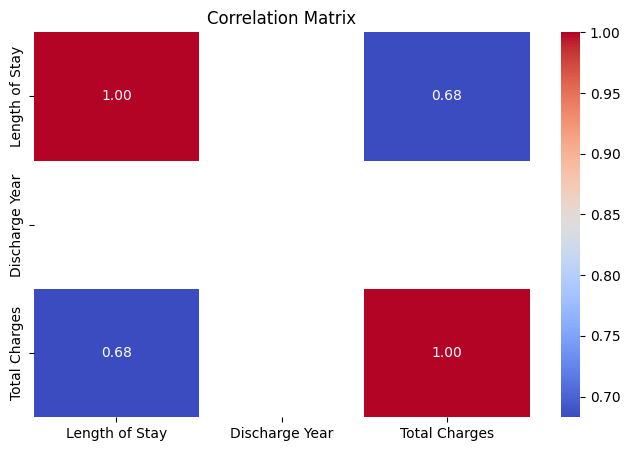

In [29]:
plt.figure(figsize=(8,5))
sns.heatmap(correleation_mattrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

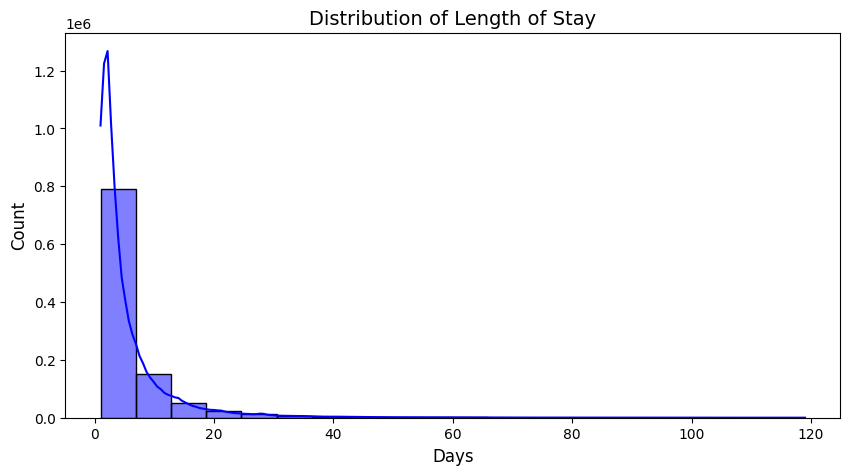

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(df_pandas["Length of Stay"], bins=20, kde=True, color="blue")
plt.title("Distribution of Length of Stay", fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

<ipython-input-31-d4bdecfd2efb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Admission Type", y="Total Charges", data=df_pandas, palette="coolwarm")


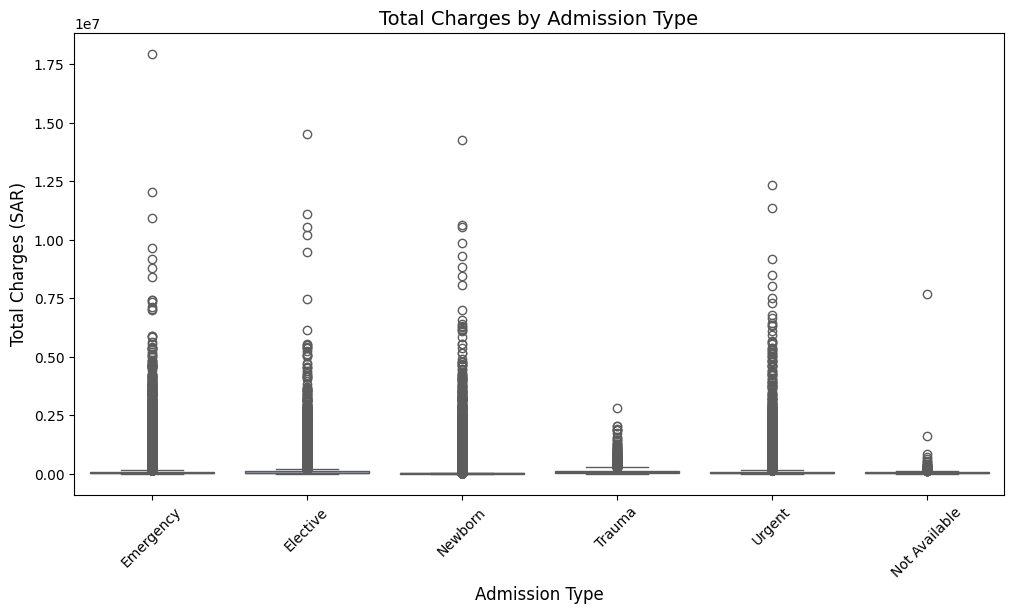

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(x="Admission Type", y="Total Charges", data=df_pandas, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Total Charges by Admission Type", fontsize=14)
plt.xlabel("Admission Type", fontsize=12)
plt.ylabel("Total Charges (SAR)", fontsize=12)
plt.show()

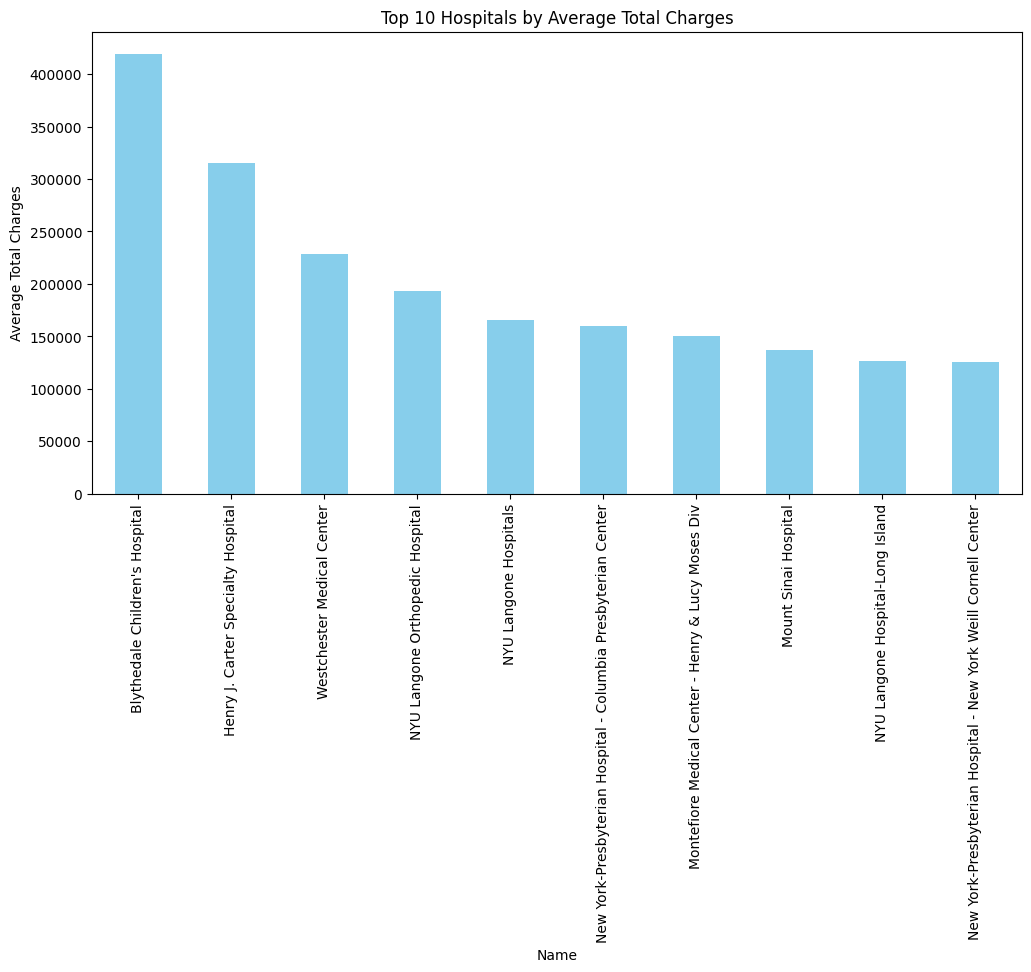

In [32]:
top_hospitals = df_pandas.groupby("Name")["Total Charges"].mean().nlargest(10)
top_hospitals.plot(kind="bar", figsize=(12,6), color="skyblue")
plt.title("Top 10 Hospitals by Average Total Charges")
plt.ylabel("Average Total Charges")
plt.show()

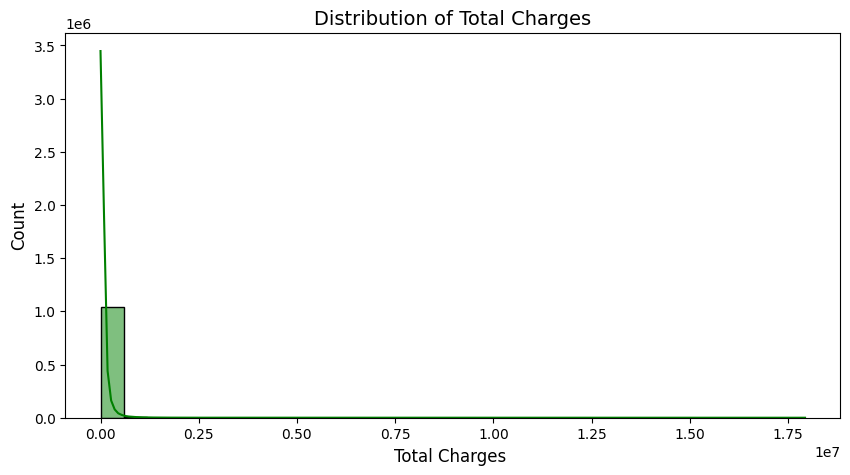

In [33]:
plt.figure(figsize=(10,5))
sns.histplot(df_pandas["Total Charges"], bins=30, kde=True, color="green")
plt.title("Distribution of Total Charges", fontsize=14)
plt.xlabel("Total Charges ", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

<ipython-input-34-c68c8fa9bf1f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y="Total Charges", data=df_pandas, palette="pastel")


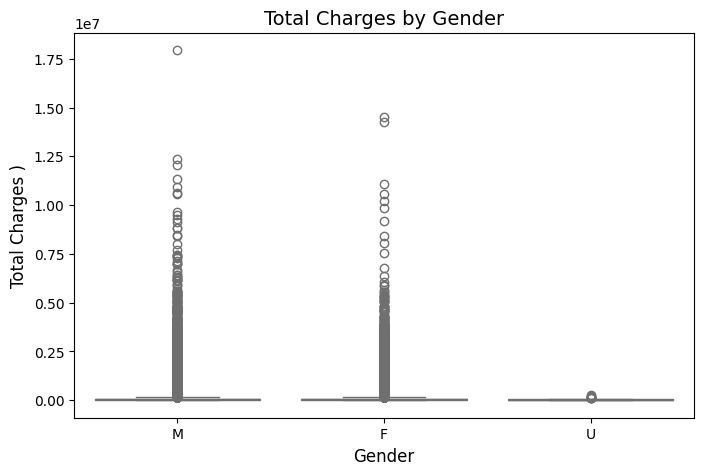

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Gender", y="Total Charges", data=df_pandas, palette="pastel")
plt.title("Total Charges by Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Total Charges )", fontsize=12)
plt.show()

In [35]:
df_cleaned = df.dropna()

In [36]:
df_cleaned = df_cleaned.dropDuplicates()


In [37]:
from pyspark.sql.functions import when, regexp_replace, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Clean currency formatting in "Total Charges" column
df_cleaned = df_cleaned.withColumn("Charges", regexp_replace("Total Charges", "[$,]", "").cast("float"))

# Create binary target column: HighCharges
df_cleaned = df_cleaned.withColumn("HighCharges", when(col("Charges") > 20000, 1).otherwise(0))


In [38]:
df_cleaned.groupBy("HighCharges").count().show()


+-----------+------+
|HighCharges| count|
+-----------+------+
|          1|772414|
|          0|250664|
+-----------+------+



In [39]:
# Oversample class 0
class_0 = df_cleaned.filter(col("HighCharges") == 0)
class_1 = df_cleaned.filter(col("HighCharges") == 1)

count_0 = class_0.count()
count_1 = class_1.count()
ratio = int(count_1 / count_0)

oversampled_class_0 = class_0
for _ in range(ratio - 1):
    oversampled_class_0 = oversampled_class_0.union(class_0)

remainder = count_1 - oversampled_class_0.count()
if remainder > 0:
    oversampled_class_0 = oversampled_class_0.union(class_0.sample(withReplacement=True, fraction=remainder / count_0))

balanced_df = oversampled_class_0.union(class_1)

# Categorical columns to encode
categorical_cols = ['Gender', 'Age Group', 'Admission Type']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx") for col in categorical_cols]

# Label column
label_indexer = StringIndexer(inputCol="HighCharges", outputCol="label")  # binary classification

# Numerical + encoded categorical features
feature_cols = ['Length of Stay'] + [col+"_idx" for col in categorical_cols]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Build pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler])
processed_data = pipeline.fit(balanced_df).transform(balanced_df)

# Train/test split
train_data, test_data = processed_data.randomSplit([0.7, 0.3], seed=42)

In [40]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator()
print("Logistic Regression AUC:", evaluator.evaluate(lr_preds))

Logistic Regression AUC: 0.8077635440570206


In [41]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

print("Random Forest AUC:", evaluator.evaluate(rf_preds))

Random Forest AUC: 0.8320985246507848


In [42]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(test_data)

print("Decision Tree AUC:", evaluator.evaluate(dt_preds))

Decision Tree AUC: 0.7500284100432719


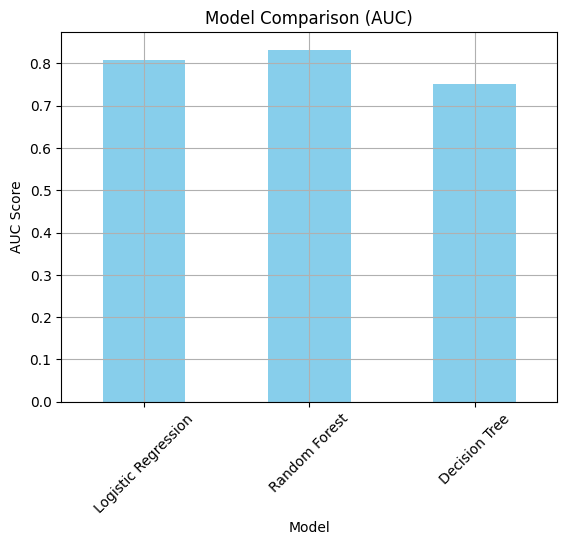

In [43]:
results = {
    "Model": ["Logistic Regression", "Random Forest", "Decision Tree"],
    "AUC": [
        evaluator.evaluate(lr_preds),
        evaluator.evaluate(rf_preds),
        evaluator.evaluate(dt_preds)
    ]
}

df_results = pd.DataFrame(results)
df_results.plot(kind="bar", x="Model", y="AUC", legend=False, color="skyblue")
plt.title("Model Comparison (AUC)")
plt.ylabel("AUC Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [44]:
# Select the features and label columns
pandas_df = processed_data.select("features", "label").toPandas()

# Convert sparse vectors to array
import numpy as np
features_array = np.array([np.array(row.features) for row in pandas_df.itertuples()])
labels_array = np.array(pandas_df["label"])

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.3, random_state=42)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Increased dropout
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Increased dropout
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile model with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,961 (35.00 KB)

 Trainable params: 8,961 (35.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
54070/54070 ━━━━━━━━━━━━━━━━━━━━ 171s 3ms/step - accuracy: 0.7172 - auc: 0.7969 - loss: 0.6598 - val_accuracy: 0.7415 - val_auc: 0.8285 - val_loss: 0.5287
Epoch 2/50
54070/54070 ━━━━━━━━━━━━━━━━━━━━ 175s 3ms/step - accuracy: 0.7391 - auc: 0.8213 - loss: 0.5350 - val_accuracy: 0.7503 - val_auc: 0.8293 - val_loss: 0.5223
Epoch 3/50
54070/54070 ━━━━━━━━━━━━━━━━━━━━ 223s 3ms/step - accuracy: 0.7424 - auc: 0.8244 - loss: 0.5287 - val_accuracy: 0.7492 - val_auc: 0.8324 - val_loss: 0.5175
Epoch 4/50
54070/54070 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - accuracy: 0.7432 - auc: 0.8253 - loss: 0.5259 - val_accuracy: 0.7501 - val_auc: 0.8323 - val_loss: 0.5160
Epoch 5/50
54070/54070 ━━━━━━━━━━━━━━━━━━━━ 201s 3ms/step - accuracy: 0.7438 - auc: 0.8258 - loss: 0.5240 - val_accuracy: 0.7509 - val_auc: 0.8343 - val_loss: 0.5146
Epoch 6/50
54070/54070 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - accuracy: 0.7444 - auc: 0.8266 - loss: 0.5222 - val_accuracy: 0.7518 - val_auc: 0.8336 - val_loss: 0.5108
Epoc

14484/14484 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.7497 - auc: 0.8383 - loss: 0.5039
Test Accuracy: 0.7491158843040466
Test AUC: 0.8379639983177185


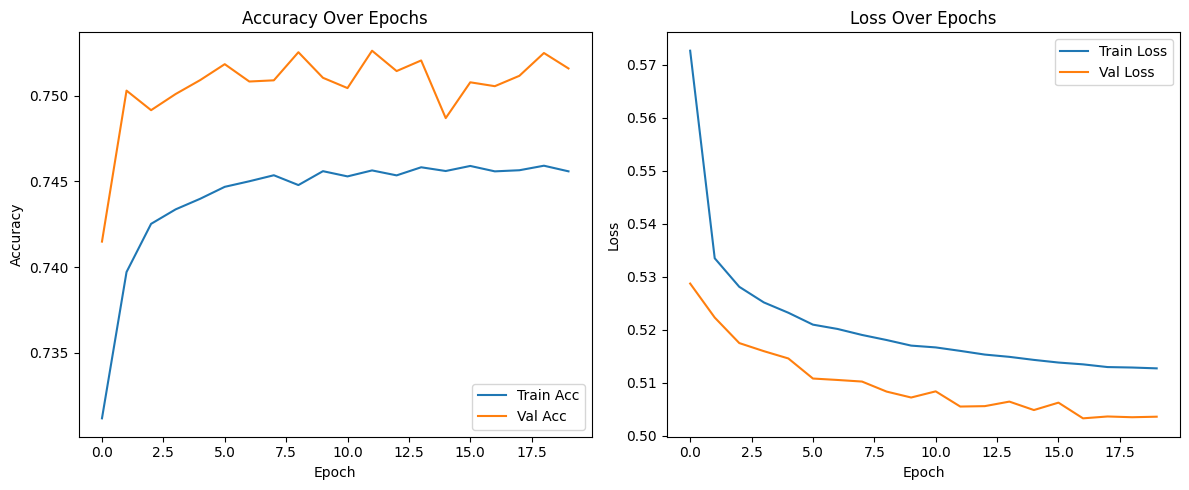

In [50]:
# Accuracy & Loss
loss, accuracy,auc = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

14484/14484 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74    231546
         1.0       0.74      0.77      0.75    231911

    accuracy                           0.75    463457
   macro avg       0.75      0.75      0.75    463457
weighted avg       0.75      0.75      0.75    463457



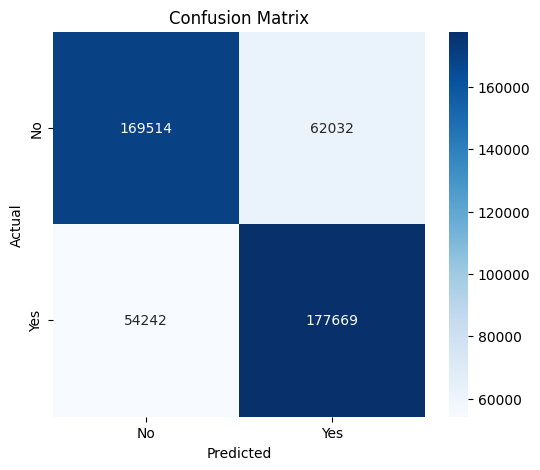

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()